# Meridian Geo-Level MMM

In this post, we build a geo-level Marketing Mix Model (MMM) using `meridian` on a large-scale dataset to evaluate its performance in estimating true marketing contributions. We'll compare the model's inferred contributions against known ground truth, providing a realistic assessment of its accuracy. Additionally, we profile the model's runtime and memory usage to understand its scalability in production-like settings.

In [1]:
import time
import re
from pympler import asizeof

from statsmodels.stats.stattools import durbin_watson

import numpy as np
import pandas as pd
import xarray as xr
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import IPython

from meridian import constants
from meridian.data import load
from meridian.data import test_utils
from meridian.data import input_data
from meridian.data import data_frame_input_data_builder
from meridian.model import model
from meridian.model import spec
from meridian.model import prior_distribution
from meridian.analysis import optimizer
from meridian.analysis import analyzer
from meridian.analysis import visualizer
from meridian.analysis import summarizer
from meridian.analysis import formatter

from pymc_marketing.paths import data_dir

import warnings
warnings.simplefilter("ignore")

In [2]:
seed: int = sum(map(ord, "mmm_multidimensional"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

### The Data

To be replaced with a larger dataset, generated by Luca.

In [3]:
data_path = data_dir / "mmm_example.csv"

raw_data_df = pd.read_csv(data_path, parse_dates=["date_week"]).rename(columns={"date_week": "date"})

a_data_df = raw_data_df.copy().assign(geo="geo_a")
b_data_df = raw_data_df.copy().assign(geo="geo_b")

# Add noise to the target variable for the second geo
b_data_df["y"] = b_data_df["y"] + 500 * rng.normal(size=len(b_data_df))

# Concatenate the two datasets
data_df = pd.concat([a_data_df, b_data_df])

# We want all geos scaled equally.
data_df['population'] = 1

# Naming convention for Meridian
data_df = data_df.rename(columns = {"date": "time"})

data_df.head()

,time,y,x1,x2,event_1,event_2,dayofyear,t,geo,population
0,2018-04-02,3984.662237,0.318580,0.0,0.0,0.0,92,0,geo_a,1
1,2018-04-09,3762.871794,0.112388,0.0,0.0,0.0,99,1,geo_a,1
2,2018-04-16,4466.967388,0.292400,0.0,0.0,0.0,106,2,geo_a,1
3,2018-04-23,3864.219373,0.071399,0.0,0.0,0.0,113,3,geo_a,1
4,2018-04-30,4441.625278,0.386745,0.0,0.0,0.0,120,4,geo_a,1


In [4]:
channel_columns = [col for col in data_df.columns if re.fullmatch(r"x\d+", col)]

builder = (
    data_frame_input_data_builder.DataFrameInputDataBuilder(kpi_type='revenue')
    .with_kpi(data_df, kpi_col="y")
    .with_population(data_df)
    .with_controls(
        data_df, control_cols=["event_1", "event_2"]
    )
    .with_media(
    data_df,
    media_cols=channel_columns,
    media_spend_cols=channel_columns,
    media_channels=channel_columns,
    )
)

data = builder.build()

### Prior Specification 

**NOTE**: Meridian doesn't have functionality to set different media priors across geos.

- Using spend shares as prior for beta parameters.
- Hierarchical structure accross the saturation parameters - Meridian does by default.
- Setting knots to occur every 26 weeks, to best align with seasonality of order 2.

In [5]:
channel_columns = [col for col in data_df.columns if re.fullmatch(r"x\d+", col)]
n_channels = len(channel_columns)

sum_spend_geo_channel = data_df.groupby("geo")[channel_columns].sum()

spend_share = (
    sum_spend_geo_channel.to_numpy() / sum_spend_geo_channel.sum(axis=1).to_numpy()[:, None]
)

prior_sigma = n_channels * spend_share
prior_sigma = prior_sigma.mean(axis = 0)

In [6]:
n_time = len(data.time)
knots = np.arange(0, n_time, 26).tolist() # ~ seasonality of order 2

In [7]:
build_media_channel_args = data.get_paid_media_channels_argument_builder()

beta_m = build_media_channel_args(
  x1=(0, float(prior_sigma[0])),
  x2=(0, float(prior_sigma[1])),
) 
beta_m_mu, beta_m_sigma = zip(*beta_m)

prior = prior_distribution.PriorDistribution(
    beta_m=tfp.distributions.LogNormal(
        beta_m_mu, beta_m_sigma, name=constants.BETA_M
    )
)

**Model Specification**

This is a geo-level model with the following specification:

$$
y_{g,t} = \mu_{t} +\tau_{g} + \sum_{i=1}^{N_C} \gamma^{[C]}_{g,i} z_{g,t,i} 
+ \sum_{i=1}^{N_M} \beta^{[M]}_{g,i} \text{HillAdstock} \left( \{ x^{[M]}_{g,t-s,i} \}_{s=0}^{L} ; \alpha^{[M]}_i, ec^{[M]}_{i}, slope^{[M]}_{i} \right) + \epsilon_{g,t}
$$

Where:

- $\mu_{t}$ represents the intercept at time $t$.
- $\tau_{g}$ represents the intercept for geo $g$.
- $\sum_{i=1}^{N_C} \gamma^{[C]}_{g,i} z_{g,t,i}$ represents the control contribution at time $t$ for geo $g$.
- $\sum_{i=1}^{N_M} \beta^{[M]}_{g,i} \text{HillAdstock} \left( \{ x^{[M]}_{g,t-s,i} \}_{s=0}^{L} ; \alpha^{[M]}_i, ec^{[M]}_{i}, slope^{[M]}_{i} \right)$ represents the adstocked saturated media contribution at time $t$ for geo $g$.
- $\epsilon_{g,t}$ represents the error at time $t$ for geo $g$

In [8]:
# MMM Model Specification

model_spec = spec.ModelSpec(
    prior=prior,
    media_effects_dist='log_normal',
    hill_before_adstock=False,
    max_lag=8,
    unique_sigma_for_each_geo=True,
    roi_calibration_period=None,
    rf_roi_calibration_period=None,
    knots=knots,
    baseline_geo=None,
    holdout_id=None,
    control_population_scaling_id=None,
    media_prior_type = 'coefficient',
    rf_prior_type = 'coefficient',
)

### Model Building

In [9]:
meridian = model.Meridian(input_data=data, model_spec=model_spec)

I0000 00:00:1751882939.172303 10741141 service.cc:148] XLA service 0x600000847000 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751882939.172341 10741141 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1751882939.181012 10741141 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


### Sample the Prior

Meridian doesn't have funcitonality to sample or plot the prior predictive.

In [10]:
meridian.sample_prior(1000)

### Model Fitting
- Inspects convergence.
- Calculates run speed.
- Calculates memory footprint.

**Note**: No progress bar.

In [11]:
start = time.perf_counter()

meridian.sample_posterior(
    n_chains=4, 
    n_adapt=1000, 
    n_burnin=500, 
    n_keep=1000)

end = time.perf_counter()
print(f"Sampling took {end - start:.2f} seconds")

2025-07-07 11:09:19.363424: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:107] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sanitize_seed/seed
W0000 00:00:1751882959.571670 10741141 assert_op.cc:38] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert


Sampling took 79.54 seconds


In [12]:
divergences = meridian.inference_data.sample_stats.diverging.sum().item()
print(f"Number of divergences: {divergences}")

r_hat_max = az.summary(
    meridian.inference_data,
    var_names=[
        "alpha_m",
        "beta_gm",
        "beta_m",
        "ec_m",
        "gamma_c",
        "gamma_gc",
        "sigma",
        "tau_g",
        "xi_c",
        "knot_values",
        "mu_t",
    ],
)['r_hat'].max()

print(f"Maximum r_hat: {r_hat_max}")

Number of divergences: 174
Maximum r_hat: 1.01


In [13]:
model_size = asizeof.asizeof(meridian)
print("Note that pymc-marketing stores the data as data objects and stores contributions as deterministics, meridian does not.")
print(f"Model size: {model_size / (1024 ** 2):.2f} MB")

Note that pymc-marketing stores the data as data objects and stores contributions as deterministics, meridian does not.
Model size: 4.85 MB


### Predictive Performance

In [14]:
model_fit = visualizer.ModelFit(meridian)
model_fit.plot_model_fit(n_top_largest_geos=2,
                         show_geo_level=True,
                         include_baseline=False,
                         include_ci=True)

alt.FacetChart(...)

In [37]:
model_analysis = analyzer.Analyzer(meridian)
fit_data = model_analysis.expected_vs_actual_data()

In [38]:
def compute_performance_metrics_by_geo(ds):
    """
    Computes R², MAPE, and Durbin-Watson stats for each geo.

    Parameters:
        ds (xarray.Dataset): Dataset with coords (geo, time) and variables: expected, actual

    Returns:
        pd.DataFrame: Table with columns: geo, R², MAPE (%), Durbin-Watson
    """
    results = []

    for geo in ds.geo.values:
        try:
            expected = ds['expected'].sel(geo=geo, metric = "mean")
            actual = ds['actual'].sel(geo=geo)

            expected_vals = expected.values
            actual_vals = actual.values

            mask = ~np.isnan(expected_vals) & ~np.isnan(actual_vals)
            expected_vals = expected_vals[mask]
            actual_vals = actual_vals[mask]

            if len(expected_vals) < 3:
                continue  # not enough data

            # R² (manual)
            ss_res = np.sum((actual_vals - expected_vals) ** 2)
            ss_tot = np.sum((actual_vals - np.mean(actual_vals)) ** 2)
            r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan

            # MAPE
            nonzero_mask = actual_vals != 0
            mape = (np.abs((actual_vals[nonzero_mask] - expected_vals[nonzero_mask]) / actual_vals[nonzero_mask])).mean() * 100

            # Durbin-Watson
            residuals = actual_vals - expected_vals
            dw = durbin_watson(residuals)

            results.append({
                "geo": geo,
                "R²": round(r2, 4) if not np.isnan(r2) else None,
                "MAPE (%)": round(mape, 2),
                "Durbin-Watson": round(dw, 3)
            })

        except Exception as e:
            print(f"Error for geo={geo}: {e}")
            continue

    return pd.DataFrame(results).sort_values("geo")
    
performance_table = compute_performance_metrics_by_geo(fit_data)
display(performance_table)

,geo,R²,MAPE (%),Durbin-Watson
0,geo_a,0.7606,8.31,0.454
1,geo_b,0.6498,10.71,1.206


## Media Effectiveness Recovery

In [16]:
# Fetch contributions over time
incremental_df = model_analysis.incremental_outcome(aggregate_times=False, aggregate_geos=False, use_kpi=True)

mean_np = mean_contributions = tf.reduce_mean(incremental_df, axis=[0,1]).numpy()
lower_np = tfp.stats.percentile(incremental_df, 3, axis=[0,1]).numpy()
upper_np = tfp.stats.percentile(incremental_df, 97, axis=[0,1]).numpy()

stacked = tf.stack([mean_np, lower_np, upper_np], axis=0).numpy()

contrib_da = xr.DataArray(
    stacked,
    dims=["hdi", "geo", "time", "media_channel"],
    coords={
        "hdi": ["mean", "lower", "upper"],
        "geo": data.geo.coords['geo'].values,
        "time": data.time.coords['time'].values,
        "media_channel": data.media.coords['media_channel'].values
    },
    name="contribution"
)

predicted_contributions_ds = contrib_da.to_dataset()

In [35]:
# Read true contributions
# contrib_df = pd.read_csv("true_output_data.csv")

In [18]:
# ---------------------------TO BE DELETED ----------------------------
contrib_df = data_df.copy()

channel_cols = [col for col in contrib_df.columns if col.startswith("x")]

for col in channel_cols:
    scaling = np.random.uniform(1000, 2000)
    contrib_df[col] = contrib_df[col] * scaling

long_contrib_df = contrib_df.melt(
    id_vars=["time", "geo"],
    value_vars=[col for col in channel_cols],
    var_name="media_channel",
    value_name="contribution"
)

long_contrib_df["media_channel"] = long_contrib_df["media_channel"]

long_contrib_df["time"] = pd.to_datetime(long_contrib_df["time"])

true_contributions_da = (
    long_contrib_df
    .set_index(["time", "geo", "media_channel"])
    .to_xarray()
)["contribution"]

true_contributions_ds = true_contributions_da.to_dataset(name="contribution")
# ---------------------------------------------------------------------

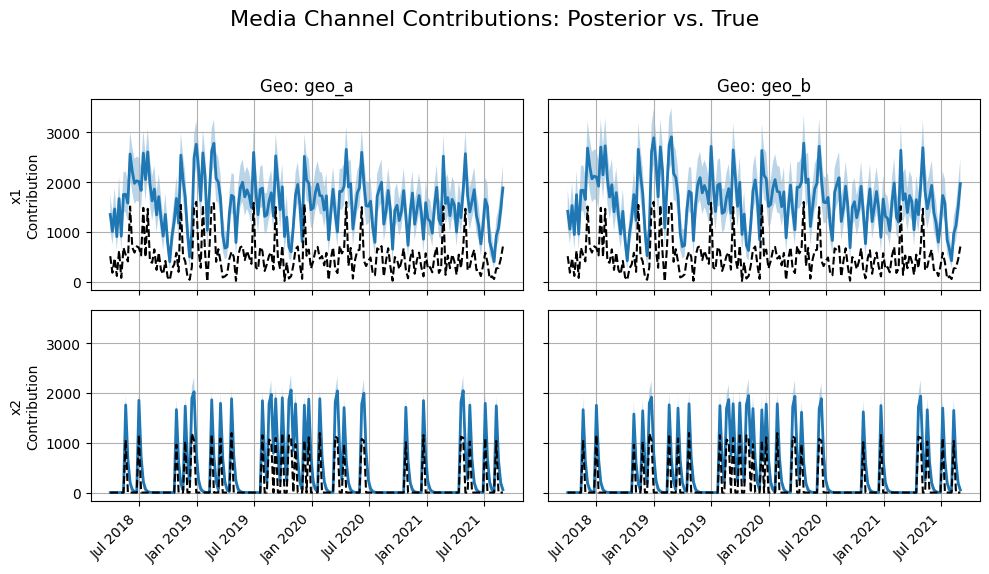

In [19]:
def plot_contributions_grid_with_truth(predicted_contributions_ds, true_contributions_ds):
    """
    Plots a grid of time series with rows = media_channel and cols = geo,
    shading between HDI bounds (lower and upper), and overlays true contributions.

    Parameters:
        predicted_contributions_ds (xarray.Dataset): Posterior Dataset with dims (hdi, geo, time, media_channel)
                                                     and coords hdi=["mean", "lower", "upper"].
        true_contributions_ds (xarray.Dataset): True contributions Dataset with dims
                                                (time, geo, media_channel) and variable "contribution".
    """
    da = predicted_contributions_ds["contribution"]

    geos = da.geo.values
    channels = da.media_channel.values
    time = pd.to_datetime(da.time.values)

    n_rows = len(channels)
    n_cols = len(geos)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3 * n_rows), sharex=True, sharey=True)
    axs = np.atleast_2d(axs)

    for i, channel in enumerate(channels):
        for j, geo in enumerate(geos):
            ax = axs[i, j]

            # Posterior mean + HDI
            mean = da.sel(hdi="mean", geo=geo, media_channel=channel)
            lower = da.sel(hdi="lower", geo=geo, media_channel=channel)
            upper = da.sel(hdi="upper", geo=geo, media_channel=channel)

            ax.plot(time, mean, label="Mean", linewidth=2)
            ax.fill_between(time, lower, upper, alpha=0.3, label="HDI (3%–97%)")

            # True contribution (from xarray)
            try:
                truth = true_contributions_ds["contribution"].sel(geo=geo, media_channel=channel)
                truth = truth.sel(time=time) 
                ax.plot(time, truth, linestyle="--", color="black", label="True", linewidth=1.5)
            except KeyError:
                pass  # Skip if combo not available

            if i == 0:
                ax.set_title(f"Geo: {geo}", fontsize=12)
            if j == 0:
                ax.set_ylabel(f"{channel}\nContribution", fontsize=10)

            ax.grid(True)
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

    for ax in axs[-1]:
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    fig.suptitle("Media Channel Contributions: Posterior vs. True", fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
plot_contributions_grid_with_truth(predicted_contributions_ds, true_contributions_ds)

In [20]:
def compute_mape_table(predicted_ds, true_ds):
    """
    Computes MAPE between predicted and true contributions for each (geo, media_channel) pair.

    Parameters:
        predicted_ds (xarray.Dataset): Dataset with dims (hdi, geo, time, media_channel)
        true_ds (xarray.Dataset): Dataset with dims (time, geo, media_channel)
        hdi_level (str): Which hdi level to use (default: "mean")

    Returns:
        pd.DataFrame: Table with columns: geo, media_channel, MAPE (%)
    """
    # Select the mean prediction
    pred_da = predicted_ds["contribution"].sel(hdi='mean')
    true_da = true_ds["contribution"]

    results = []

    for geo in pred_da.coords["geo"].values:
        for channel in pred_da.coords["media_channel"].values:
            try:
                # Select predicted and true time series
                pred = pred_da.sel(geo=geo, media_channel=channel)
                true = true_da.sel(geo=geo, media_channel=channel)

                # Convert to pandas Series indexed by time
                pred_series = pd.Series(pred.values, index=pred.coords["time"].values)
                true_series = pd.Series(true.values, index=true.coords["time"].values)
                pred_series.index = pd.to_datetime(pred_series.index)
                true_series.index = pd.to_datetime(true_series.index)

                # Join and clean
                df = pd.DataFrame({"pred": pred_series, "true": true_series}).dropna()
                df = df[df["true"] != 0]

                if not df.empty:
                    mape = (np.abs((df["true"] - df["pred"]) / df["true"])).mean() * 100
                    results.append({
                        "geo": geo,
                        "media_channel": channel,
                        "MAPE (%)": round(mape, 2)
                    })

            except KeyError:
                continue

    return pd.DataFrame(results).sort_values(["geo", "media_channel"])


In [21]:
mape_df = compute_mape_table(predicted_contributions_ds, true_contributions_ds)
mape_df

,geo,media_channel,MAPE (%)
0,geo_a,x1,803.28
1,geo_a,x2,70.19
2,geo_b,x1,845.25
3,geo_b,x2,61.04
